## Gets rid of the annoying scroll bars for larger outputs.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import print_function

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# You will likely have to install some packages for these imports to work;
# run this in a shell: pip install numpy pandas matplotlib pandas-profiling scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# xgboost is a library with really really good models (we can go over gradient boosting next ML lesson);
# it can be a bitch to install though so we'll comment it out now.
#from xgboost import XGBClassifier

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Read in the train data that's used for selecting a model and fine-tuning that model's hyperparameters... <br> also read in the test data that's used to make our final predictions for evaluation by the Kaggle platform.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## pandas_profiling is a sexy data exploration tool that I wish I found out about earlier... <br> it shows you all the good stuff

In [4]:
pandas_profiling.ProfileReport(train)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


## There's a lot to be unpacked from this initial look at the data. Some key points to note: <br>
&emsp; (1) Missing values -- out of the 891 rows in the training set: <br>
&emsp; &emsp; - AGE is missing 177 <br>
&emsp; &emsp; - CABIN is missing 687 <br>
&emsp; &emsp; - EMBARKED is missing 2 <br>
&emsp; &emsp; For some features, like EMBARKED, imputing with the mode of that feature, S, is sensible. For other features, like AGE, it's not so clear what the <br> 
&emsp; &emsp; best approach is...maybe imputing with the mean of 29.7 is best? CABIN is missing for most of the samples; it might be best to just remove this <br> 
&emsp; &emsp; feature all together! <br>
&emsp; (2) Data types: <br>
&emsp; &emsp; - PASSENGERID is not to be considered; it carries no information and is only used to ID our predictions when submitting for evaluation. <br>
&emsp; &emsp; - SURVIVED is not to be considered; these are the labels to be used during training. <br> 
&emsp; &emsp; - CABIN is going to be dropped as explained above. <br>
&emsp; &emsp; - NAME doesn't seem to carry any information; each value is unique and, if there was any information between the samples of this feature, we'd have <br> 
&emsp; &emsp;   to use some tricky NLP techniques to capture that which is out of the scope of this exercise. Let's drop this feature. <br>
&emsp; &emsp; - TICKET might contain some information, but it isn't apparent to me how it can be used...if we look at the discussion or search online, we can see that <br>
&emsp; &emsp;   people are somehow using it to make predictions, but let's not concern ourselves with that and stick to the basics. Let's drop this features. <br>
&emsp; &emsp; - AGE, FARE, PARCH, PCLASS, SIBSP are all numerical already. <br>
&emsp; &emsp; - all of the remaining features are text strings so something must be done to make them categorical. <br>
&emsp; &emsp; - EMBARKED and SEX need to be turned into numerical categorical values. <br>
&emsp; (3) Correlations: <br>
&emsp; &emsp; - The strongest correlation is between PCLASS and FARE, which makes perfect sense; the highest class passengers spent the most for their tickets. <br>
&emsp; &emsp; - Looking along the SURVIVED row, we can see that PCLASS and FARE are the strongest indicators of survival. <br>
&emsp; &emsp; These things are interesting to note, our model will probably highly weight these feature when making predictions.

## More on data types

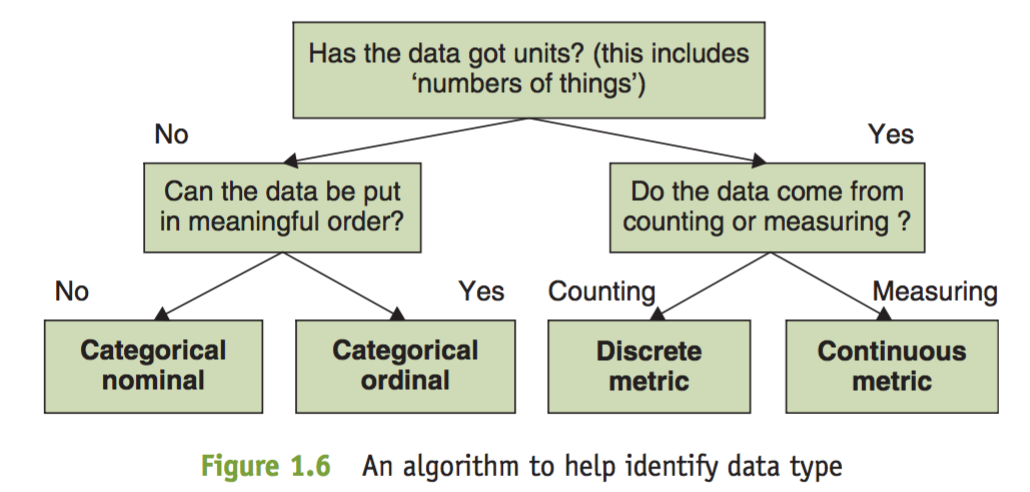

In [5]:
from IPython.display import Image
Image("data_types.png")

Out of our original twelve columns of the train data, we're only keeping seven: AGE, FARE, PARCH, SIBSP, PCLASS, EMBARKED, and SEX.

We need to group these by their data type: numerical (discrete/continuous) and categorical (nominal/ordinal).

AGE, FARE, PARCH, and SIBSP are all clearly numerical -- AGE and FARE are continuous while PARCH and SIBSP are discrete.

PCLASS is categorical; furthermore, it is an ordinal data type because there is a notion of ordering within the values -- 1 is the highest class ticket, 2 is lower class, while 3 is lower than 2 (1 < 2 < 3 numerical ordering => 1 > 2 > 3 logical ordering).

EMBARKED and SEX are nominal because there is no ordering between the values of these features -- e.g. male is not greater than or less than female.

For SEX, we can reduce this to a simple feature called GENDER which is either 0 or 1. 

For EMBARKED, we cannot use three values (0, 1, and 2) to represent the embarked ports because the model would interpret values of 1 as being somehow inbetween values 0 and 2 -- what we want the model to see is that a sample is in one of three distinct categories...not somewhere on a sliding scale that contains these three values and supports some relation between them. To fix this, we convert EMBARKED into dummy variables a.k.a one-hot encoding...

If you had three samples whose feature values are 1, 2 and 3, the samples would look like this: [1, 2, 3]

The one-hot encoding of those samples would look like this: [[1, 0, 0], [0, 1, 0], [0, 0, 1]].

Actually, a more appropriate representation would be this: [[0, 0], [1, 0], [0, 1]]. Look up dummy variables / one-hot encoding to learn more about why we do this.

So we will convert our EMBARKED feature into two features, EMBARKED_1 and EMBARKED_2. If a sample has a value of S for EMBARKED, we set EMBARKED_1 and EMBARKED_2 to 0 -- if a sample has a value of C, we set EMBARKED_1 to 1 and EMBARKED_2 to 0, and if a sample has a value of Q, we set EMBARKED_1 to 0 and EMBARKED_2 to 1. 

## Data preparation

In [5]:
# Remove unnecessary features.
train = train.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])

# Also remove these features from the test set.
ids = test['PassengerId']
test = test.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])

# Separate labels from the train data.
y = train['Survived']
X = train.drop(columns=['Survived'])

# Impute missing values for AGE and EMBARKED.
X['Age'] = X['Age'].fillna(X['Age'].mean())
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])  # Mode returns a list since there may be multiple

We can see that the test set has missing values also, so these must be imputed using the mean/mode from the TRAIN DATA:

In [6]:
test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
# Impute the missing values in the test data using statistics from the train data.
test['Age'] = test['Age'].fillna(X['Age'].mean())
test['Fare'] = test['Fare'].fillna(X['Fare'].mean())

In [8]:
# Convert SEX values to 0 and 1.
le = LabelEncoder()
# We want to fit the label encoder using both train and test data 
# incase there are values present in one and not in the other.
le.fit(pd.concat([X['Sex'], test['Sex']]))  # Fitting the label encoder maps observed values to the range (0, N-1).
X['Sex'] = le.transform(X['Sex'])           # Change the column values for SEX to the respective nominal values.
test['Sex'] = le.transform(test['Sex'])     # Do this for the test set also.

In [9]:
# Convert EMBARKED values to 0, 1, 2...
le = LabelEncoder()
le.fit(pd.concat([X['Embarked'], test['Embarked']]))
X['Embarked'] = le.transform(X['Embarked'])           
test['Embarked'] = le.transform(test['Embarked'])  

# and then one-hot encode them.
ohe = OneHotEncoder()
ohe.fit(pd.concat([X['Embarked'], pd.DataFrame(test['Embarked'].values.reshape(-1, 1))]))

# Apply these changes to both the train and test data.
for data in [X, test]:
    # Convert EMBARKED values into their one-hot encoding representation.
    new_features = ohe.transform(data['Embarked'].values.reshape(-1, 1)).todense()
    
    # Create a new column for each one-hot encoding position (EMBARKED_1, EMBARKED_2).
    for i, feat in enumerate(new_features.T[1:], 1):
        feat = feat.reshape(-1, 1)
        data['Embarked_' + str(i)] = feat
        
# Get rid of the unnecessary EMBARKED column.
X = X.drop(columns=['Embarked'])
test = test.drop(columns=['Embarked'])

## Scale all the numerical and ordinal features -- there are a bunch of different scaling methods; we're going to use sklearn's MinMaxScaler here.

In [10]:
for feat in ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']:
    scaler = MinMaxScaler()
    
    # Make sure features have the right shape and then convert them back into DataFrame objects.
    train_vals = pd.DataFrame(X[feat].values.reshape(-1, 1))
    test_vals = pd.DataFrame(test[feat].values.reshape(-1, 1))
    
    # Fit to the train data and then transform the train and test data.
    scaler.fit(train_vals)
    X[feat] = scaler.transform(train_vals)
    test[feat] = scaler.transform(test_vals)

## Let's take a look at the train and test sets again to ensure that all our values are encoded and scaled properly. 

In [11]:
X.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.647587,0.367921,0.065376,0.063599,0.062858,0.086420,0.725028
std,0.418036,0.477990,0.163383,0.137843,0.134343,0.096995,0.281141,0.446751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.271174,0.000000,0.000000,0.015440,0.000000,0.000000
50%,1.000000,1.000000,0.367921,0.000000,0.000000,0.028213,0.000000,1.000000
75%,1.000000,1.000000,0.434531,0.125000,0.000000,0.060508,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.632775,0.636364,0.373644,0.055921,0.065391,0.069524,0.110048,0.645933
std,0.420919,0.481622,0.158792,0.112095,0.163571,0.108994,0.313324,0.478803
min,0.000000,0.000000,-0.003141,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.283740,0.000000,0.000000,0.015412,0.000000,0.000000
50%,1.000000,1.000000,0.367921,0.000000,0.000000,0.028213,0.000000,1.000000
75%,1.000000,1.000000,0.443956,0.125000,0.000000,0.061484,0.000000,1.000000
max,1.000000,1.000000,0.949736,1.000000,1.500000,1.000000,1.000000,1.000000


## Good, our data has no missing values, all the categorical data is encoded properly, and all our numerical and ordinal values are scaled to the inclusive range (0, 1) -- we're ready to start building some models and evaluating them.

First build a list of tuples where each tuple is a (model class, parameters dictionary) pair. You can supply an empty parameter dictionary to try the default values for that model class. I recommend looking at the sklearn docs to see the various parameters and then plugging in a range of values to try. See what parameter values yield the best results and then refine the list to close in on those values at a higher resolution.

In [14]:
models = [
            (GaussianNB, {}),
            (DecisionTreeClassifier, {'criterion': ['gini', 'entropy']}),
            (LogisticRegression,
                    {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
            (KNeighborsClassifier, {'n_neighbors': [10,11,12,13,14,15]}),
            (RandomForestClassifier,
                    {'criterion': ['gini', 'entropy'],
                     'n_estimators': [10,11,12,13,14,15],
                     'max_depth': [None,8,9,10,11,12]}),
            (SVC, [{'kernel': ['linear'],
                      'C': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 10]},
                     {'kernel': ['rbf'],
                      'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5],
                      'gamma': ['auto', 8, 9, 10, 11, 12, 13, 14, 15]}
                     ])
          ]

What we're going to do is iterate over the models and their hyperparameters to grid search over. Models that have an element of randomness to them should be instantiated with some RANDOM_STATE constant so that the results are deterministic. GRIDSEARCHCV will enumerate all combinations of hyperparameters and build a model for each of these combinations, then it will train the model a number of times equal to CV.

CV stands for cross-validation. We want to validate our model on a subset of our labeled data -- we can't use the test set because (a) we don't have labels for it and (b) the test set is never used to select/tune your model...the test set is only used to get a final evaluation for your model and then you stop changing the model (otherwise we risk overfitting to the data we have which would cause our model to have an increased generalization error a.k.a worse performance in the real world).

K-fold cross-validation is the process of segmenting our training data into K equal sized portions and iteratively training the same model on K-1 of the subsets and testing on the remaining portion. After doing this K times, you average the result for the final CV score. 10 is a common CV value.

In [15]:
trained = []

for model, params in models:

    if type(model()).__name__ in ['GaussianNB', 'KNeighborsClassifier']:
        m = model()
    else:
        m = model(random_state=42)

    grid = GridSearchCV(estimator=m, param_grid=params, cv=10, n_jobs=-1)
    grid.fit(X, y)
    score = grid.score(X, y)
    pred = grid.predict(X)
    print("Grid:\n", grid)
    print("Training score:", score)
    print("Best cross-validation score:", grid.best_score_)
    print("Best params:", grid.best_params_)
    print("Classification report:\n{}\n\n".format(classification_report(y, pred)))

    trained.append((grid.best_score_, grid.best_estimator_))

Grid:
 GridSearchCV(cv=10, error_score='raise', estimator=GaussianNB(priors=None),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Training score: 0.7890011223344556
Best cross-validation score: 0.7822671156004489
Best params: {}
Classification report:
             precision    recall  f1-score   support

          0       0.82      0.84      0.83       549
          1       0.73      0.71      0.72       342

avg / total       0.79      0.79      0.79       891



Grid:
 GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
 

## Evaluation

We can look at the outputs of our grid search to get an idea of how the models are doing. If the training score is much higher than the best CV score, that's an indication that the model is overfitting to the training data i.e. it has high variance -- the model is memorizing the training data in a way that leads it to make wrong assumptions about unseen data. Ways to combat overfitting include: <br>
&emsp; - getting more data <br>
&emsp; - applying regularization techniques which prevent the model from overweighting certain predictive features <br>

If the training score is really low, the model is underfitting i.e. it has high bias --  the main way to prevent underfitting is to add complexity to the model...more features, more parameters, etc.

In [17]:
best_model = sorted(trained, reverse=True)[0][1]
print("Best model is", type(best_model).__name__, "with a cross-validation score of", sorted(trained, reverse=True)[0][0])
predictions = best_model.predict(test).astype(int)

with open('submission.csv', 'w') as f:
    f.write('item_id,category_class\n')
    for item_id, prediction in zip(ids, predictions):
        f.write("{},{}\n".format(item_id, prediction))

Best model is RandomForestClassifier with a cross-validation score of 0.835016835016835
